# 植物幼苗识别

分类过程将包括以下步骤:

- 获取数据：读取图像和标签。
- 清洗数据：去除图像背景，输入标准化和标签准备。
- 创建模型：创建训练和验证集，创建和拟合模型。
- 评价模型：评价模型，进行预测。

## 1、获取数据

获取图像并调整大小为70x70像素。我们使用70 x 70像素的大小来快速训练模型。我们还可以从文件夹名称中获取图像标签。

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
from glob import glob
import math

ScaleTo = 70  # px to scale
seed = 7  # fixing random

path = './input/train/*/*.png' 
files = glob(path)

trainImg = []
trainLabel = []
j = 1
num = len(files)

# Obtain images and resizing, obtain labels
for img in files:
    print(str(j) + "/" + str(num), end="\r")
    trainImg.append(cv2.resize(cv2.imread(img), (ScaleTo, ScaleTo)))  # Get image (with resizing)
    trainLabel.append(img.split('/')[-2])  # Get image label (folder name)
    j += 1

trainImg = np.asarray(trainImg)  # Train images set
trainLabel = pd.DataFrame(trainLabel)  # Train labels set

让我们看一些植物照片的例子

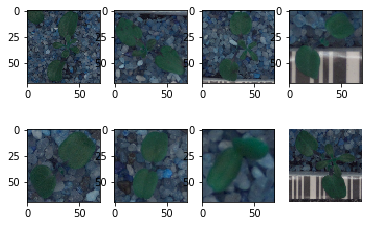

In [8]:
# Show some example images
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(trainImg[i])
plt.axis('off')
plt.show()

我们可以看到，每一张植物幼苗的照片都有一个背景，所以我们试着把它移除。它将帮助我们实现更好的模型精度。

## 2、清洗数据

为了去除背景，我们将使用这个事实，我们照片上的所有植物都是绿色的。我们可以创建一个蒙版（遮罩），它会留下一些绿色的颜色，去掉其他部分的图像。

### 2.1 掩蔽绿色植物

为了创建可以消除背景的蒙版，我们需要将RGB图像转换为HSV。 HSV是RGB颜色模型的替代品。 在HSV中，表示颜色范围比在RGB颜色空间中更容易。

除此之外，我们还会先模糊图像来去除噪声。创建HSV图像后，我们将根据经验选择的绿色颜色范围创建蒙版，将其转换为布尔蒙版，并将其应用到原始图像。

1. 使用高斯模糊去除噪声。
2. 将颜色转换为HSV
3. 创建蒙版
4. 创建布尔蒙版
5. 应用布尔蒙版并获取没有背景的图像。

In [9]:
clearTrainImg = []
examples = []; getEx = True
for img in trainImg:
    # Use gaussian blur
    blurImg = cv2.GaussianBlur(img, (5, 5), 0)
    
    # Convert to HSV image
    hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)
    
    # Create mask (parameters - green color range)
    lower_green = (25, 40, 50)
    upper_green = (75, 255, 255)
    mask = cv2.inRange(hsvImg, lower_green, upper_green)  
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))  # 获取结构元素。MORPH_ELLIPSE：椭圆
    # 腐蚀：某一点的像素值，就是核与图像该部分像素值差的最小值。所以像素值变低比较容易，亮色部分被腐蚀。
    # 膨胀：某一点的像素值，就是核与图像该部分像素值和的最大值。所以像素值变高比较容易，亮色部分膨胀。
    # 开运算：先腐蚀后膨胀，作用：放大裂缝和低密度区域，消除小物体，在平滑较大物体的边界时，不改变其面积
    # 闭运算：先膨胀后腐蚀，作用：排除小型黑洞，突出了比原图轮廓区域更暗的区域
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)  # 图像膨胀/腐蚀。MORPH_CLOSE：闭操作
    
    # Create bool mask
    bMask = mask > 0  
    
    # Apply the mask
    clear = np.zeros_like(img, np.uint8)  # Create empty image
    clear[bMask] = img[bMask]  # Apply boolean mask to the origin image
    
    clearTrainImg.append(clear)  # Append image without backgroung
    
    # Show examples
    if getEx:
        plt.subplot(2, 3, 1); plt.imshow(img)  # Show the original image
        plt.subplot(2, 3, 2); plt.imshow(blurImg)  # Blur image
        plt.subplot(2, 3, 3); plt.imshow(hsvImg)  # HSV image
        plt.subplot(2, 3, 4); plt.imshow(mask)  # Mask
        plt.subplot(2, 3, 5); plt.imshow(bMask)  # Boolean mask
        plt.subplot(2, 3, 6); plt.imshow(clear)  # Image without background
        getEx = False
        
clearTrainImg = np.asarray(clearTrainImg)

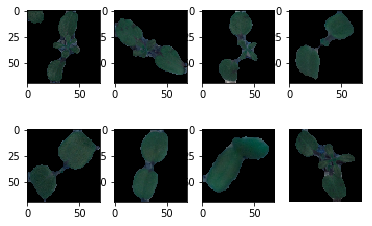

In [10]:
# Show sample result
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(clearTrainImg[i])
plt.axis('off')
plt.show()

正如我们看到的那样，背景被很好的移除了

### 2.2 标准化输入

现在将输入值[0...255]设置为[0...1]（RGB颜色空间编码颜色[0...255]）。标准化输入能使CNN更快。

In [11]:
clearTrainImg = clearTrainImg / 255

### 2.3 标签编码

对图像标签进行编码。标签是12个字符串名称，

Classes: ['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed' 'Shepherds Purse'
 'Small-flowered Cranesbill' 'Sugar beet']
Number of classes: 12


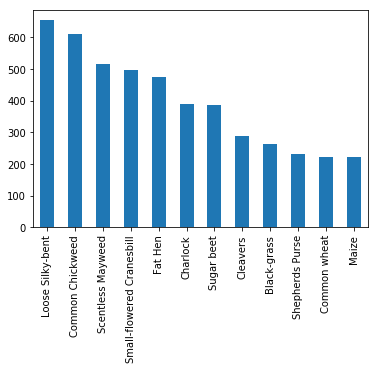

In [14]:
from keras.utils import np_utils
from sklearn import preprocessing
import matplotlib.pyplot as plt

# Encode labels and create classes
le = preprocessing.LabelEncoder()
le.fit(trainLabel[0])
print("Classes: " + str(le.classes_))
encodeTrainLabels = le.transform(trainLabel[0])

# Make labels categorical
clearTrainLabel = np_utils.to_categorical(encodeTrainLabels)
num_clases = clearTrainLabel.shape[1]
print("Number of classes: " + str(num_clases))

# Plot of label types numbers
trainLabel[0].value_counts().plot(kind='bar')
plt.show()

正如我们所看到的，我们对不同物种的图像有不同的计数。因此,数据分布是不平衡的。

## 3、模型

### 3.1 分割数据集

在训练和验证集上分割数据。10%的数据成为验证集。

我们的数据分布是不平衡的，所以为了避免不准确地评价模型集：stratify=clearTrainLabel。

In [15]:
from sklearn.model_selection import train_test_split

trainX, testX, trainY, testY = train_test_split(clearTrainImg, clearTrainLabel, 
                                                test_size=0.1, random_state=seed, 
                                                stratify = clearTrainLabel)

### 3.2 数据生成

为了避免过度拟合，我们需要创建图像生成器，它将在模型拟合期间随机旋转、缩放、移动和翻转图像。

- 从0到180度设置随机旋转
- 将随机缩放设置为0.1
- 将随机移位设置为0.1
- 设置水平和垂直翻转

In [16]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=180,  # randomly rotate images in the range
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically 
        horizontal_flip=True,  # randomly flip images horizontally
        vertical_flip=True  # randomly flip images vertically
    )  
datagen.fit(trainX)

### 3.3 创建模型

使用了Keras Sequential创建模型。

最终创建了六个卷积层和三个全连接层的模型。
前两个卷积层有64个滤波器，接下来是128个滤波器，最后两个层有256个滤波器。在每一对卷积层模型中都有最大池化层。 
此外，为了减少每对卷积层之后的过拟合，我们使用dropout层（卷积层之间为10％，全连接层之间为50％），并在每层之间使用batch normalization层。

最后，我使用了三个全连接层来进行分类。在最后一层，神经网络输出12个类别中每一个的概率分布。

In [17]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization

numpy.random.seed(seed)  # Fix seed

model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(ScaleTo, ScaleTo, 3), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=128, kernel_size=(5, 5), activation1='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(num_clases, activation='softmax'))

model.summary()

# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 66, 66, 64)        4864      
_________________________________________________________________
batch_normalization_1 (Batch (None, 66, 66, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 31, 31, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 27, 128)       204928    
__________

### 3.4 拟合模型

接下来我们将训练模型。首先我们设置了降低模型学习率的回调。如果三个周期后的准确性没有提高，我们会降低学习率。其他两个回调可以保存最佳模型的权重。

我们不会在kaggle内核上训练模型，因为它的过程太长，所以注释了拟合的代码行。

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger

# learning rate reduction
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.4, 
                                            min_lr=0.00001)

# checkpoints
filepath="./weights.best_{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', 
                             verbose=1, save_best_only=True, mode='max')
filepath="./weights.last_auto4.hdf5"
checkpoint_all = ModelCheckpoint(filepath, monitor='val_acc', 
                                 verbose=1, save_best_only=False, mode='max')

# all callbacks
callbacks_list = [checkpoint, learning_rate_reduction, checkpoint_all]

# fit model
hist = model.fit_generator(datagen.flow(trainX, trainY, batch_size=75), 
                           epochs=1, validation_data=(testX, testY), 
                           steps_per_epoch=trainX.shape[0], callbacks=callbacks_list)

## 4、评价模型

### 4.1 从文件加载模型

这里我们从文件中加载最佳拟合模型的权重（使用之前训练过的kaggle数据集和模型的权重）。 另外，我从Data.npz训练和验证数据集加载，该模型适合评估模型精度。

In [ ]:
model.load_weights("./weights.best_17-0.96.hdf5")

data = np.load("./Data.npz")
d = dict(zip(("trainX","testX","trainY", "testY"), (data[k] for k in data)))
trainX = d['trainX']
testX = d['testX']
trainY = d['trainY']
testY = d['testY']

print(model.evaluate(trainX, trainY))  # Evaluate on train set
print(model.evaluate(testX, testY))  # Evaluate on test set

### 4.2 混淆矩阵

这是查看模型错误的好方法

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    fig = plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
predY = model.predict(testX)
predYClasses = np.argmax(predY, axis = 1) 
trueY = np.argmax(testY, axis = 1) 

# confusion matrix
confusionMTX = confusion_matrix(trueY, predYClasses) 

# plot the confusion matrix
plot_confusion_matrix(confusionMTX, classes = le.classes_) 

### 4.3 获取结果

最后我们得到测试数据的预测结果

In [ ]:
path = '../input/plant-seedlings-classification/test/*.png'
files = glob(path)

testImg = []
testId = []
j = 1
num = len(files)

# Obtain images and resizing, obtain labels
for img in files:
    print("Obtain images: " + str(j) + "/" + str(num), end='\r')
    testId.append(img.split('/')[-1])  # Images id's
    testImg.append(cv2.resize(cv2.imread(img), (ScaleTo, ScaleTo)))
    j += 1

testImg = np.asarray(testImg)  # Train images set

for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(testImg[i])
plt.axis('off')
plt.show()

In [ ]:
clearTestImg = []
examples = []; getEx = True
for img in testImg:
    # Use gaussian blur
    blurImg = cv2.GaussianBlur(img, (5, 5), 0)   
    
    # Convert to HSV image
    hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)  
    
    # Create mask (parameters - green color range)
    lower_green = (25, 40, 50)
    upper_green = (75, 255, 255)
    mask = cv2.inRange(hsvImg, lower_green, upper_green)  
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Create bool mask
    bMask = mask > 0  
    
    # Apply the mask
    clear = np.zeros_like(img, np.uint8)  # Create empty image
    clear[bMask] = img[bMask]  # Apply boolean mask to the origin image
    
    clearTestImg.append(clear)  # Append image without backgroung
    
    # Show examples
    if getEx:
        plt.subplot(2, 3, 1); plt.imshow(img)  # Show the original image
        plt.subplot(2, 3, 2); plt.imshow(blurImg)  # Blur image
        plt.subplot(2, 3, 3); plt.imshow(hsvImg)  # HSV image
        plt.subplot(2, 3, 4); plt.imshow(mask)  # Mask
        plt.subplot(2, 3, 5); plt.imshow(bMask)  # Boolean mask
        plt.subplot(2, 3, 6); plt.imshow(clear)  # Image without background
        getEx = False

clearTestImg = np.asarray(clearTestImg)

In [ ]:
# Show sample result
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(clearTestImg[i])
plt.axis('off')
plt.show()

In [ ]:
clearTestImg = clearTestImg / 255
pred = model.predict(clearTestImg)

In [ ]:
# Write result to file
predNum = np.argmax(pred, axis=1)
predStr = le.classes_[predNum]

res = {'file': testId, 'species': predStr}
res = pd.DataFrame(res)
res.to_csv("./output/result.csv", index=False)